In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [73]:
data = np.load("../../Data/development.npy")
data_csv = pd.read_csv("../../Data/metadata/development.csv")
idx_to_feature_name = pd.read_csv("../../Data/metadata/idx_to_feature_name.csv")

In [74]:
labels = data_csv['word']
y = {}
labels_new = []
i = 0
for label in np.unique(labels).tolist():
    y[label] = i
    i += 1
for label in labels:
    labels_new.append(y[label])

In [75]:
#data_new = np.concatenate((data[:, :11, :], data[:, 171:, :]), axis=1)
#data_test = np.concatenate((data[:4, :11, :], data[:4, 76:, :]), axis=1)
data_train = np.concatenate((data[:36236, :22, :], data[:36236, 87:, :]), axis=1)
data_valid = np.concatenate((data[36236:, :22, :], data[36236:, 87:, :]), axis=1)
#data_train = data[:36236, :, :]
#data_valid = data[36236:, :, :]
print(data_train.shape, data_valid.shape)

(36236, 110, 44) (9060, 110, 44)


In [76]:
labels_train = labels_new[:36236]
labels_valid = labels_new[36236:]

In [77]:
X_tensor_train = torch.tensor(data_train, dtype=torch.float32)
y_tensor_train = torch.tensor(labels_train, dtype=torch.long)
X_tensor_valid = torch.tensor(data_valid, dtype=torch.float32)
y_tensor_valid = torch.tensor(labels_valid, dtype=torch.long)

In [78]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [99]:
class AudioCNN(nn.Module):
    def __init__(self):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(32 * 43 * 11, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 21)
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 43 * 11)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.output(x)
        return x
    
class SimplestAudioCNN(nn.Module):
    def __init__(self):
        super(SimplestAudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(3, 3), padding=1)  # Reduced the number of filters
        self.pool = nn.MaxPool2d(2, 2)
        # One Convolutional layer followed by pooling
        self.fc1 = nn.Linear(8 * 87 * 22, 50)  # Reduced number of neurons, and adjusted for new output size
        self.fc2 = nn.Linear(50, 21)  # Output layer remains the same, 21 classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(-1, 8 * 87 * 22)  # Flatten the output for the dense layer
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class MinimalAudioCNN(nn.Module):
    def __init__(self):
        super(MinimalAudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=(3, 3), padding=1)  # Only 4 filters
        self.pool = nn.MaxPool2d(2, 2)  # Pooling to reduce spatial dimensions
        self.fc1 = nn.Linear(4 * 87 * 22, 21)  # Directly connecting to output layer
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Applying convolution then pooling
        x = x.view(-1, 4 * 87 * 22)  # Flatten the output for the dense layer
        x = self.fc1(x)  # Only one linear layer directly to outputs
        return x
    
class ModifiedAudioCNN(nn.Module):
    def __init__(self):
        super(ModifiedAudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(4)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4 * 87 * 22, 21)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = x.view(-1, 4 * 87 * 22)
        x = self.fc1(x)
        return x

class EnhancedAudioCNN(nn.Module):
    def __init__(self):
        super(EnhancedAudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32, momentum=0.01)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(64, momentum=0.1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1)
        self.bn3 = nn.BatchNorm2d(128, momentum=0.1)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=(3, 3), padding=1)
        self.bn4 = nn.BatchNorm2d(64, momentum=0.1)
        self.fc1 = nn.Linear(64 * 6 * 2, 32)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(32, 21)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.dropout1(x)
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.dropout2(x)
        x = x.view(-1, 64 * 6 * 2)  # Adjust the flattening to new layer dimensions
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


In [108]:
model = EnhancedAudioCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=0.0001)

dataset_train = CustomDataset(X_tensor_train, y_tensor_train)
dataloader_train = DataLoader(dataset_train, batch_size=128, shuffle=True, drop_last=True)

dataset_valid = CustomDataset(X_tensor_valid, y_tensor_valid)
dataloader_valid = DataLoader(dataset_valid, batch_size=128, shuffle=False, drop_last=True)

use_mps = torch.backends.mps.is_available()
device = torch.device("mps" if use_mps else "cpu")

model.to(device)

EnhancedAudioCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=768, out_features=32, bias=True)
  (relu): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=32, out_features=21, bias=True)
)

In [109]:
# Example training loop
num_epochs = 20
#total_iterations = num_epochs * (len(dataloader_train) + len(dataloader_valid))
#progress_bar = tqdm(total=total_iterations, desc='Training and Evaluation')

losses_train = []
losses_valid = []

for epoch in range(num_epochs):
    model.train()
    for features, labels in dataloader_train:
        optimizer.zero_grad()
        features = features.unsqueeze(1)
        inputs = features.to(device)
        targets = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
    losses_train.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        for features, labels in dataloader_valid:
            inputs = features.to(device)
            inputs = inputs.unsqueeze(1)
            targets = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        losses_valid.append(loss.item())
    if losses_train[-1] < 3 and losses_valid[-1] < 3:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, f'model_epoch_{epoch}.pth')
    #progress_bar.update(2)
    print(f'Epoch {epoch + 1}/{num_epochs}, Training loss: {losses_train[-1]}, Validation loss: {losses_valid[-1]}')

Epoch 1/20, Training loss: 2.8572702407836914, Validation loss: 7.840262413024902
Epoch 2/20, Training loss: 2.7532858848571777, Validation loss: 7.4338884353637695
Epoch 3/20, Training loss: 2.765103578567505, Validation loss: 7.878308296203613
Epoch 4/20, Training loss: 3.001337766647339, Validation loss: 7.531655311584473
Epoch 5/20, Training loss: 2.808495283126831, Validation loss: 7.795297622680664
Epoch 6/20, Training loss: 2.791691303253174, Validation loss: 7.9648613929748535
Epoch 7/20, Training loss: 2.7675232887268066, Validation loss: 7.927440643310547
Epoch 8/20, Training loss: 2.709097385406494, Validation loss: 8.017860412597656
Epoch 9/20, Training loss: 2.8289127349853516, Validation loss: 7.955453872680664
Epoch 10/20, Training loss: 2.738433361053467, Validation loss: 7.713958740234375
Epoch 11/20, Training loss: 2.641927719116211, Validation loss: 8.173614501953125
Epoch 12/20, Training loss: 2.6378698348999023, Validation loss: 7.985819339752197
Epoch 13/20, Train

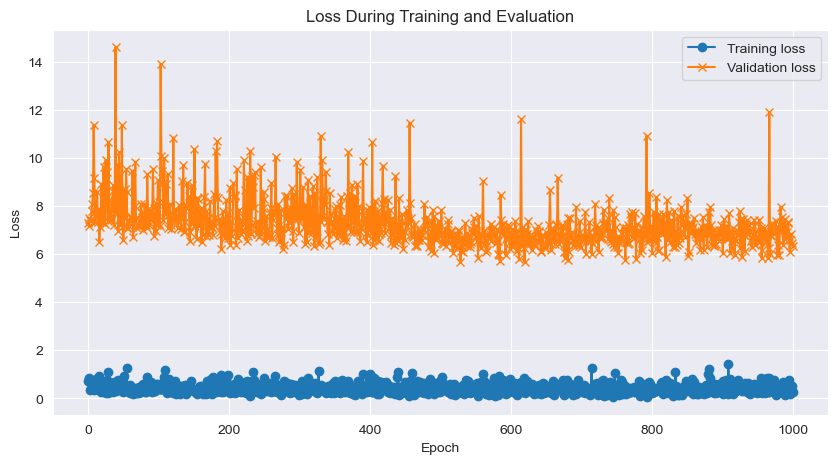

In [106]:
import matplotlib.pyplot as plt

# Assuming 'losses' is a list of float numbers representing the loss values
plt.figure(figsize=(10, 5))  # Set the figure size (optional)
plt.plot(losses_train, label='Training loss', marker='o')
plt.plot(losses_valid, label='Validation loss', marker='x')  # Plot the losses with line and markers
plt.title('Loss During Training and Evaluation')  # Give the plot a title
plt.xlabel('Epoch')  # Label the x-axis as 'Epoch'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.grid(True)  # Enable grid for easier readability
plt.legend()
plt.show()  # Display the plot

In [30]:
print(losses_train[-1])

1.954041838645935
